In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSD
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning, module="MDAnalysis.coordinates.DCD")
warnings.filterwarnings('ignore', category=UserWarning, module='MDAnalysis')

# Definindo o caminho dos arquivos
topology_path = "/media/leon/FEDF-FDB3/md_thil_10replicates_100ns/1_replica/water_remov/1/5cc8_wr_1.prmtop"
trajectory_path = "/media/leon/FEDF-FDB3/md_thil_10replicates_100ns/1_replica/water_remov/1/5cc8_wr_1.dcd"


# Carregando a topologia e a trajetória
u = mda.Universe(topology_path, trajectory_path)

# Selecionando os átomos do backbone (CA, C, O, N)
backbone_atoms = u.select_atoms("backbone and (name CA or name C or name O or name N)")

# Inicializando a análise de RMSD
rmsd_analysis = RMSD(backbone_atoms, reference=backbone_atoms, ref_frame=0)
rmsd_analysis.run()

# Convertendo os resultados para um DataFrame do pandas para facilitar a exportação para CSV
rmsd_results = pd.DataFrame(rmsd_analysis.results.rmsd, columns=["Frame", "Time (ps)", "RMSD"])

# Salvando os resultados em um arquivo CSV
csv_path = "./1_rmsd.csv"  # Escolha seu caminho de salvamento preferido
rmsd_results.to_csv(csv_path, index=False)

print(f"RMSD data saved to {csv_path}")

RMSD data saved to ./1_rmsd.csv


In [2]:
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
# Realizando o teste de Shapiro-Wilk
shapiro_test = shapiro(rmsd_results['RMSD'].values)

# Definindo o nível de significância
alpha = 0.05

# Imprimindo os resultados
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

# Decidindo se rejeita a hipótese nula
if shapiro_test[1] < alpha:
    print("Rejeitamos a hipótese nula: os dados não seguem uma distribuição normal.")
else:
    print("Não rejeitamos a hipótese nula: os dados podem seguir uma distribuição normal.")

Shapiro-Wilk test statistic: 0.924407958984375, p-value: 0.0
Rejeitamos a hipótese nula: os dados não seguem uma distribuição normal.


In [3]:
estatisticas_descritivas = rmsd_results['RMSD'].describe()
print(estatisticas_descritivas)

count    25000.000000
mean         4.923701
std          1.377423
min          0.000002
25%          3.852407
50%          5.363428
75%          6.079225
max          7.231082
Name: RMSD, dtype: float64


In [7]:
import pandas as pd


# Obtendo os valores de interesse
valores_de_interesse = {
    'min': estatisticas_descritivas['min'],
    'mean': estatisticas_descritivas['mean'],
    'std': estatisticas_descritivas['std'],
    '25%': estatisticas_descritivas['25%'],
    '50%': estatisticas_descritivas['50%'],
    '75%': estatisticas_descritivas['75%'],
    'max': estatisticas_descritivas['max']
}

# Lista para armazenar os frames selecionados
frames_selecionados = []

# Buscando os frames que mais se aproximam dos valores de interesse
for descricao, valor in valores_de_interesse.items():
    # Encontrando o índice do frame cujo valor de RMSD é o mais próximo do valor de interesse
    idx = (rmsd_results['RMSD'] - valor).abs().idxmin()
    frame_selecionado = rmsd_results.iloc[idx]
    frames_selecionados.append({
        'frame': frame_selecionado['Frame'],
        'rmsd': frame_selecionado['RMSD'],
        'descricao': descricao
    })

# Convertendo a lista de frames selecionados em um DataFrame para fácil manipulação
selected_frames = pd.DataFrame(frames_selecionados)

# Mostrando os frames selecionados
print(selected_frames)

     frame      rmsd descricao
0      0.0  0.000002       min
1  14731.0  4.923561      mean
2    191.0  1.375035       std
3   5475.0  3.852428       25%
4  15317.0  5.363403       50%
5  17718.0  6.079216       75%
6  23357.0  7.231082       max


In [8]:
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='MDAnalysis')

# Criando a pasta para salvar os arquivos PDB, se ainda não existir
output_directory = "pdb_md_representative"
os.makedirs(output_directory, exist_ok=True)

# Iterando sobre os frames selecionados para salvar como PDB
for index, row in selected_frames.iterrows():
    descricao = row['descricao']  # Descrição (min, 25%, 50%, 75%, max)
    descricao = descricao.replace('%', '')  # Removendo o símbolo '%' da descrição
    frame_index = int(row['frame'])  # Índice do frame selecionado
    
    # Acessando o frame específico
    u.trajectory[frame_index]
    
    # Definindo o nome do arquivo PDB com descrição e índice do frame
    # Nome do arquivo sem o símbolo '%'
    pdb_filename = os.path.join(output_directory, f"{descricao}_frame_{frame_index}.pdb")
    
    # Salvando o frame atual como um arquivo PDB
    u.atoms.write(pdb_filename)

print("Arquivos PDB dos frames selecionados foram salvos com as descrições ajustadas.")


Arquivos PDB dos frames selecionados foram salvos com as descrições ajustadas.


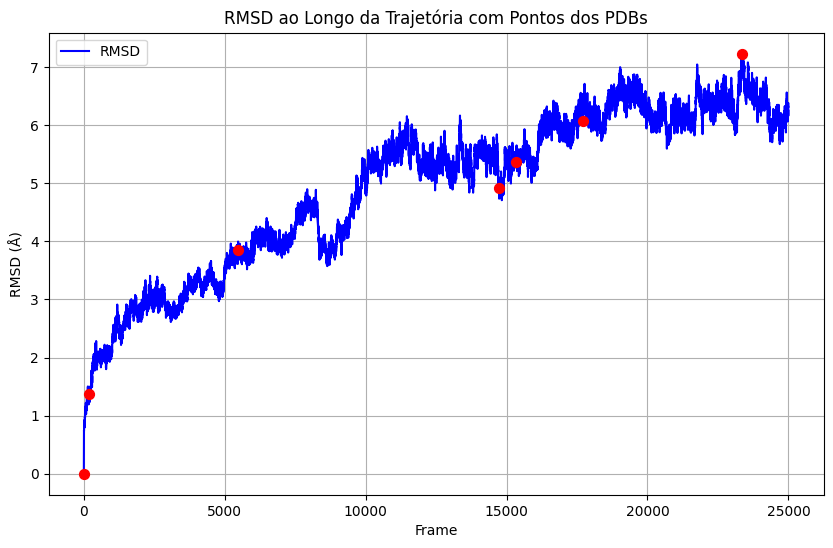

In [9]:
import matplotlib.pyplot as plt

# Supondo que rmsd_results e selected_frames estão definidos corretamente
# Primeiro, plota o RMSD ao longo de todos os frames
plt.figure(figsize=(10, 6))
plt.plot(rmsd_results['Frame'], rmsd_results['RMSD'], label='RMSD', color='blue')

# Em seguida, plota os pontos específicos onde os PDBs foram retirados
# Para cada frame selecionado, encontra o RMSD correspondente e plota o ponto
for frame in selected_frames['frame']:
    rmsd_value = rmsd_results.loc[rmsd_results['Frame'] == frame, 'RMSD'].values[0]
    plt.scatter(frame, rmsd_value, color='red', s=50, zorder=5)  # zorder=5 para garantir que os pontos fiquem acima da linha

plt.title('RMSD ao Longo da Trajetória com Pontos dos PDBs')
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.legend()
plt.grid(True)
plt.show()
